In [1]:
import numpy as np
from scipy import optimize as optimize
import matplotlib.pyplot as plt
import time

## Exercise 2.1

In [2]:
# wage, rent, utility and derivative of utility

def get_L(nvec):
    return np.sum(np.array(nvec))

def get_K(bvec):
    return np.sum(np.array(bvec))

def get_w(nvec, bvec, params):
    A, α = params
    w = (1-α) * A * (get_K(bvec)/get_L(nvec))**α
    return w

def get_r(nvec, bvec, params):
    A, α, δ = params
    r = α * A * (get_L(nvec)/get_K(bvec))**(1-α) - δ
    return r

def get_u(c, params):
    σ = params
    u = (c**(1-σ) - 1) / (1 - σ)
    return u

def get_uprime(c, params):
    σ = params
    mu = c**(-σ)
    return mu

def get_Y(nvec, bvec, params):
    A, α = params
    L = get_L(nvec)
    K = get_K(bvec)
    Y = A * K**α * L**(1 - α)
    return Y

def get_c(nvec, bvec, params):
    A, α, δ = params
    
    n1, n2, n3 = nvec
    b2, b3 = bvec
    w_params = A, α
    r_params = A, α, δ
    
    w = get_w(nvec, bvec, w_params)
    r = get_r(nvec, bvec, r_params)
    
    c1 = n1 * w - b2
    c2 = n2 * w + (1 + r) * b2 - b3
    c3 = (1 + r) * b3 + n3 * w
    
    return c1, c2, c3

In [3]:
def feasible(f_params, bvec_guess):
    b_cnstr = np.full(2, False)
    c_cnstr = np.full(3, False)
    K_cnstr = np.full(1, False)
    
    # unpack parameters
    α, β, δ, σ, A = f_params
    
    nvec = (1, 1, 0.2) # use default values as not specified
    w_params = A, α
    r_params = A, α, δ
    c_params = A, α, δ
    
    w = get_w(nvec, bvec_guess, w_params)
    r = get_r(nvec, bvec_guess, r_params)
    
    c = get_c(nvec, bvec_guess, c_params)
    
    for i in range(3):
        if c[i] < 0:
            c_cnstr[i] = True
        else:
            c_cnstr[i] = False
            
    if c_cnstr[0] == True:
        b_cnstr[0] = True
    elif c_cnstr[1] == True:
        b_cnstr = [True, True]
    elif c_cnstr[2] == True:
        b_cnstr[1] = True
    
    if get_K(bvec_guess) > 0:
        K = [True]
    
    return b_cnstr, c_cnstr, K_cnstr

In [4]:
# parameters
def f_params():
    β = 0.442
    δ = 0.6415
    σ = 3
    A = 1
    α = 0.35
    return α, β, δ, σ, A

### 2.1a

In [5]:
feasible(f_params(), [1.0, 1.2])

(array([ True, False]), array([ True, False, False]), array([False]))

Nonnegativity constraint of c1 is violated, likely to be caused by b2

### 2.1b

In [6]:
feasible(f_params(), [0.06, -0.001])

(array([False, False]), array([False, False, False]), array([False]))

No constraint is violated

### 2.1c

In [7]:
feasible(f_params(), [0.1, 0.1])

(array([False, False]), array([False, False, False]), array([False]))

No constraint is violated

## Exercise 2.2

In [8]:
def eqbm(bvec, w, r, params):

    β, σ, nvec, L, A, α, δ, SS_tol = params
    
    w_params = A, α
    r_params = A, α, δ
    c_params = A, α, δ
    
    w = get_w(nvec, bvec, w_params)
    r = get_r(nvec, bvec, r_params)
    
    c1bar, c2bar, c3bar = get_c(nvec, bvec, c_params)
    
    mu1 = get_uprime(c1bar, σ)
    mu2 = get_uprime(c2bar, σ)
    mu3 = get_uprime(c3bar, σ)
    
    f1 = mu1 - β * (1 + r) * mu2
    f2 = mu2 - β * (1 + r) * mu3

    return f1, f2

In [9]:
def get_SS(params, bvec_guess, SS_graphs = True):
    
    #start time
    start_time = time.time()
    
    #unpack parameters
    β, σ, nvec, L, A, α, δ, SS_tol = params
    
    w_params = A, α
    r_params = A, α, δ
    c_params = A, α, δ
    Y_params = A, α
    
    w = get_w(nvec, bvec_guess, w_params)
    r = get_r(nvec, bvec_guess, r_params)
    
    #find root
    b_ss = optimize.fsolve(eqbm, bvec_guess, args = (w, r, params), xtol = SS_tol)
    b2bar, b3bar = b_ss
    
    #compute all steady state variables
    c_ss = get_c(nvec, b_ss, c_params)
    w_ss = get_w(nvec, b_ss, w_params)
    r_ss = get_r(nvec, b_ss, r_params)
    K_ss = get_K(b_ss)
    Y_ss = get_Y(nvec, b_ss, Y_params)
    C_ss = np.sum(c_ss)
    EulErr_ss = eqbm(b_ss, w_ss, r_ss, params)
    RCerr_ss = Y_ss - C_ss - δ * K_ss
    ss_time = time.time() - start_time
    
    if SS_graphs == True:
        plt.figure(figsize = (7,7))
        plt.plot([2,3], b_ss, '-o', label = 'savings')
        plt.plot([1,2,3], c_ss, '-o', label = 'consumption')
        plt.xlabel('age')
        plt.xticks([1,2,3])
        plt.ylabel('savings and consumption')
        plt.title('savings and consumption vs. age')
        plt.legend()
        plt.grid()
        plt.show()
    
    results = dict({'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss, 
                    'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
                    'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
                    'ss_time': ss_time})
    return results

### 2.2a and b

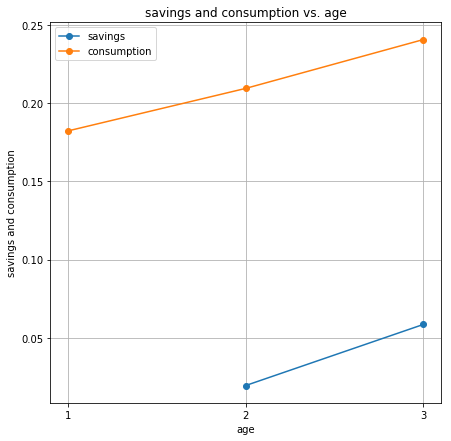

{'b_ss': array([0.01931253, 0.0584111 ]),
 'c_ss': (0.18241212755849867, 0.20961468030898922, 0.24087386507209851),
 'w_ss': 0.20172465739052575,
 'r_ss': 2.433062339127069,
 'K_ss': 0.07772362575316386,
 'Y_ss': 0.6827603788602411,
 'C_ss': 0.6329006729395864,
 'EulErr_ss': (-1.3926637620897964e-12, 2.6290081223123707e-12),
 'RCerr_ss': 8.326672684688674e-17,
 'ss_time': 0.003039836883544922}

In [10]:
def params1():
    β = 0.442
    δ = 0.6415
    σ = 3
    A = 1
    α = 0.35
    nvec = np.array([1, 1, 0.2])
    L = np.sum(nvec)
    SS_tol = 1e-8
    return β, σ, nvec, L, A, α, δ, SS_tol

bvec_guess = [0.1, 0.1]

ss1 = get_SS(params1(), bvec_guess)
ss1

### 2.2c

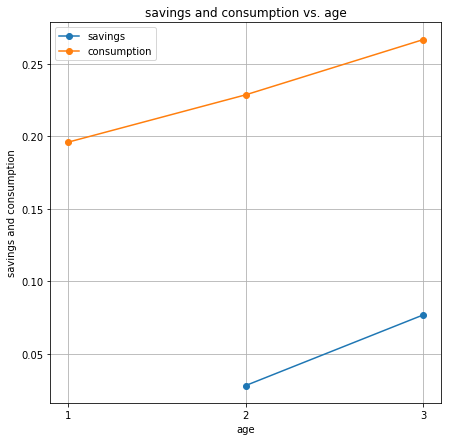

{'b_ss': array([0.02817692, 0.07686545]),
 'c_ss': (0.19597527701928497, 0.2286159413839988, 0.26669307195186887),
 'w_ss': 0.22415219593446706,
 'r_ss': 1.8863765057189819,
 'K_ss': 0.1050423702259807,
 'Y_ss': 0.7586689708551193,
 'C_ss': 0.6912842903551526,
 'EulErr_ss': (6.87805368215777e-12, 2.5295321393059567e-12),
 'RCerr_ss': 9.71445146547012e-17,
 'ss_time': 0.0011010169982910156}

In [11]:
def params2():
    β = 0.55
    δ = 0.6415
    σ = 3
    A = 1
    α = 0.35
    nvec = np.array([1, 1, 0.2])
    L = np.sum(nvec)
    SS_tol = 1e-8
    return β, σ, nvec, L, A, α, δ, SS_tol

bvec_guess = [0.1, 0.1]

ss2 = get_SS(params2(), bvec_guess)
ss2

In [12]:
difference = ss1
for i in ss1.keys():
    difference[i] = np.array(ss2[i]) - np.array(ss1[i])
difference

{'b_ss': array([0.00886439, 0.01845436]),
 'c_ss': array([0.01356315, 0.01900126, 0.02581921]),
 'w_ss': 0.022427538543941306,
 'r_ss': -0.5466858334080873,
 'K_ss': 0.027318744472816847,
 'Y_ss': 0.0759085919948782,
 'C_ss': 0.05838361741556619,
 'EulErr_ss': array([ 8.27071744e-12, -9.94759830e-14]),
 'RCerr_ss': 1.3877787807814457e-17,
 'ss_time': -0.0019388198852539062}

Everything increases except rent.  
This can be interpreted as ...